Usando il dispositivo: cpu
Caricamento dei dataset...
Inizio training...

Epoch 1/20


Train Loss: 1.6150, Acc: 0.1865 | Val Loss: 1.6082, Acc: 0.2128
Modello salvato (nuovo best)

Fine training. Miglior acc. validazione: 0.2128

Epoch 2/20


Train Loss: 1.6102, Acc: 0.2121 | Val Loss: 1.6076, Acc: 0.2128
Nessun miglioramento da 1 epoche.

Fine training. Miglior acc. validazione: 0.2128

Epoch 3/20


Train Loss: 1.6075, Acc: 0.2051 | Val Loss: 1.5954, Acc: 0.2340
Modello salvato (nuovo best)

Fine training. Miglior acc. validazione: 0.2340

Epoch 4/20


Train Loss: 1.5051, Acc: 0.3054 | Val Loss: 1.3219, Acc: 0.3723
Modello salvato (nuovo best)

Fine training. Miglior acc. validazione: 0.3723

Epoch 5/20


Train Loss: 1.5910, Acc: 0.4266 | Val Loss: 2.1644, Acc: 0.2660
Nessun miglioramento da 1 epoche.

Fine training. Miglior acc. validazione: 0.3723

Epoch 6/20


Train Loss: 1.7639, Acc: 0.2587 | Val Loss: 1.4797, Acc: 0.3298
Nessun miglioramento da 2 epoche.

Fine training. Miglior acc. validazione: 0.3723

Epoch 7/20


Train Loss: 1.5134, Acc: 0.2774 | Val Loss: 1.4427, Acc: 0.3511
Nessun miglioramento da 3 epoche.

Fine training. Miglior acc. validazione: 0.3723

Epoch 8/20


Train Loss: 1.4628, Acc: 0.3497 | Val Loss: 1.3920, Acc: 0.3617
Nessun miglioramento da 4 epoche.

Fine training. Miglior acc. validazione: 0.3723

Epoch 9/20


Train Loss: 1.4485, Acc: 0.3380 | Val Loss: 1.3713, Acc: 0.3511
Nessun miglioramento da 5 epoche.
Early stopping attivato dopo 9 epoche.


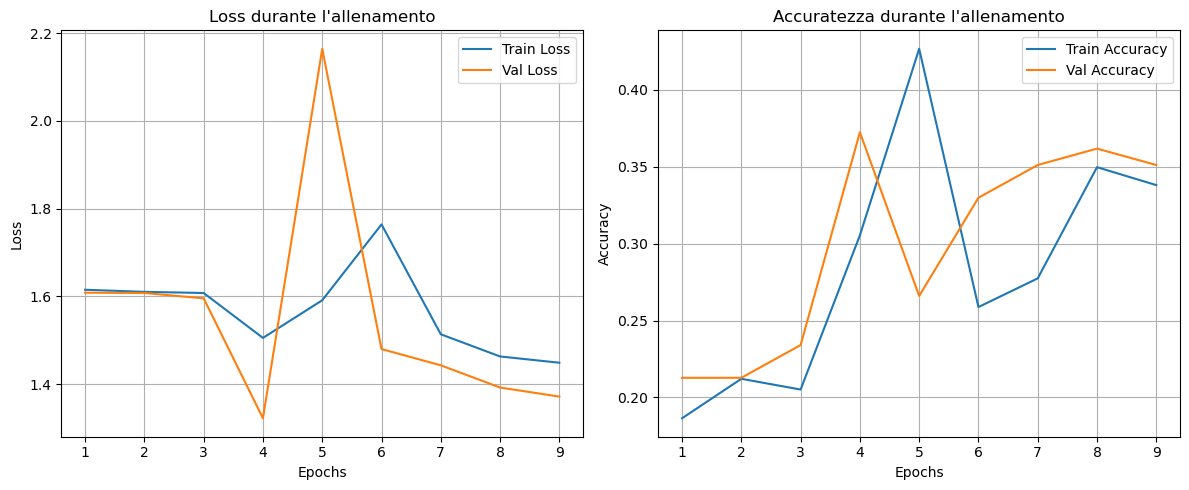

Test finale sul dataset di test...


c:\Users\Samanta\Desktop\Giovanni\Classification-instruments\utils\test_audio.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path

<Figure size 1000x800 with 0 Axes>

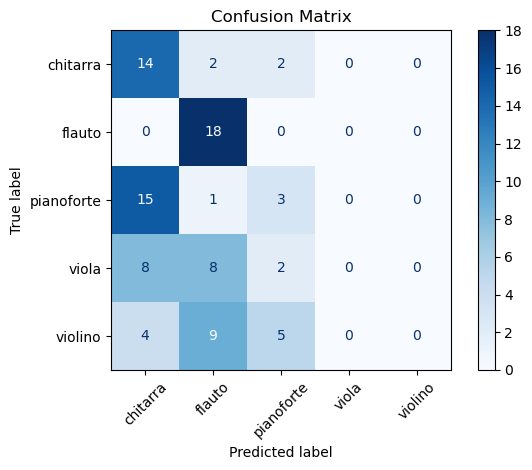

Salvataggio log...


In [1]:
import torch
from torch.utils.data import DataLoader
from utils.train_audio import train_model
from utils.dataset_audio import AudioDataset
from utils.dataset_audio import collate_fn
from models.model_audio import RNN
from utils.test_audio import test_model
from utils.predict_audio import log_results, plot_metrics, plot_confusion_matrix

if __name__ == "__main__":
    root_data = "data"
    batch_size = 32
    epochs = 20
    learning_rate = 1e-3
    sample_rate = 16000
    save_path = "best_model.pth"
    log_file = "log.txt"
    bidirectional = True

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Usando il dispositivo: {device}")

    print("Caricamento dei dataset...")
    train_dataset = AudioDataset(root_data, split="train", sample_rate=sample_rate)
    val_dataset = AudioDataset(root_data, split="val", sample_rate=sample_rate)
    test_dataset = AudioDataset(root_data, split="test", sample_rate=sample_rate)

    label_mapping = train_dataset.get_label_mapping()
    num_classes = len(label_mapping)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

    model = RNN(
        input_size=1,
        hidden_size=128,
        num_layers=3,
        num_classes=num_classes,
        bidirectional=bidirectional
    )

    print("Inizio training...")
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader,
        num_epochs=epochs, lr=learning_rate,
        device=device, save_path=save_path
    )
    
    
    plot_metrics(train_loss, val_loss, train_acc, val_acc)
    print("Test finale sul dataset di test...")
    test_acc, y_true, y_pred = test_model(model, test_loader, device=device, model_path=save_path)
    plot_confusion_matrix(y_true, y_pred, class_names=list(label_mapping.keys()))


    print("Salvataggio log...")
    log_results(log_file, final_test_accuracy=test_acc, epochs=epochs, learning_rate=learning_rate)

    # predict_single_file(model, "esempio.wav", label_mapping, device=device, sample_rate=sample_rate, model_path=save_path)